In [ ]:
import qrcode
import numpy as np
from PIL import Image, ImageDraw
import random
import matplotlib.pyplot as plt
import skimage, skimage.io
import cv2
import torch
%matplotlib inline

In [1]:
link = "https://www.google.com/"

Generate Various QR Codes Begin --------

In [234]:
def generate_qrcode(data, output_path="qrcode_output.png"):
    """
    Returns:
        numpy.ndarray: Depth map (binary map) of the QR code.
        PIL.Image.Image: The generated QR code as a PIL Image.
    """
    qr = qrcode.QRCode(
        version=40,  # Adjust version for QR code complexity
        error_correction=qrcode.constants.ERROR_CORRECT_H,
        box_size=1,
        border=0, 
    )
    qr.add_data(data)
    qr.make(fit=True)

    qr_matrix = np.array(qr.get_matrix(), dtype=np.uint8)  # Binary QR code matrix (0s and 1s)
    
    depth_map = np.array(qr_matrix, dtype=np.float32)  # Convert to float32 for compatibility
    
    img = qr.make_image(fill_color="black", back_color="white").convert("RGB")
    #img.save(output_path)
    
    return depth_map, img

texture, qr_image = generate_qrcode(link, output_path="qrcode_V1.png")
qr_image.show()

In [238]:
def generate_greyScl_qrcode(data, dot_size=5, output_path="qrcode_V0.png"):
    """
    Returns:
        numpy.ndarray: Depth map for the QR code.
        PIL.Image.Image: The generated pattern as a PIL image.
    """
    qr = qrcode.QRCode(
        version=40,
        error_correction=qrcode.constants.ERROR_CORRECT_H,
        box_size=1,
        border=0,
    )
    qr.add_data(data)
    qr.make(fit=True)
    qr_matrix = np.array(qr.get_matrix(), dtype=np.uint8)

    # Convert QR code matrix to depth map (binary map)
    depth_map = np.array(qr_matrix, dtype=np.float32)

    # Create a random pattern for the background
    qr_size = qr_matrix.shape[0]
    pattern_width = qr_size * dot_size
    pattern = np.random.randint(0, 255, (pattern_width, pattern_width), dtype=np.uint8)

    # Create the QR code pattern with the random background
    img = Image.new("L", (pattern_width, pattern_width), "white")  # Grayscale image
    draw = ImageDraw.Draw(img)

    for row_index, row in enumerate(qr_matrix):
        for col_index, pixel in enumerate(row):
            if pixel:  # Black in QR code
                x = col_index * dot_size
                y = row_index * dot_size
                draw.rectangle(
                    [x, y, x + dot_size - 1, y + dot_size - 1],
                    fill=int(pattern[row_index * dot_size, col_index * dot_size]),
                )

    #img.save(output_path)
    return depth_map, img

texture, pattern_image = generate_greyScl_qrcode(link, dot_size=5, output_path="qrcode_greyScl_V1.png")
pattern_image.show()

In [240]:
def generate_qrcode_random_colors(data, dot_size=5, output_path="random_colored_qrcode.png"):
    """
    Returns:
        numpy.ndarray: Depth map (binary map) of the QR code.
        PIL.Image.Image: The generated QR code as a PIL Image.
    """
    qr = qrcode.QRCode(
        version=1,  # Adjust version for QR code complexity
        error_correction=qrcode.constants.ERROR_CORRECT_H,
        box_size=1,
        border=0,  # Standard border size
    )
    qr.add_data(data)
    qr.make(fit=True)
    
    qr_matrix = np.array(qr.get_matrix(), dtype=np.uint8)  # Binary QR code matrix (0s and 1s)
    
    depth_map = np.array(qr_matrix, dtype=np.float32)  # Convert to float32 for compatibility
    
    qr_size = len(qr_matrix)  # Number of rows/columns in the QR code matrix
    img_size = qr_size * dot_size
    img = Image.new("RGB", (img_size, img_size), "white")
    draw = ImageDraw.Draw(img)

    for row_index, row in enumerate(qr_matrix):
        for col_index, pixel in enumerate(row):
            if pixel:  # Black in the QR code
                x = col_index * dot_size
                y = row_index * dot_size
                # Random color for each black dot
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
                draw.rectangle(
                    [x, y, x + dot_size - 1, y + dot_size - 1],
                    fill=color
                )

    #img.save(output_path)
    
    return depth_map, img

texture, random_colored_qr = generate_qrcode_random_colors(link, dot_size=5, output_path="qr_rdmClr_V1.png")
random_colored_qr.show()

In [243]:
def generate_qrcode_gradient(data, dot_size=5, output_path="qr_gradient.png", center_color=(0, 0, 255), edge_color=(255, 255, 0)):
    """
    Returns:
        numpy.ndarray: Depth map (binary map) of the QR code.
        PIL.Image.Image: The generated QR code as a PIL Image.
    """
    qr = qrcode.QRCode(
        version=1,  # Adjust version for QR code complexity
        error_correction=qrcode.constants.ERROR_CORRECT_H,
        box_size=1,
        border=0, 
    )
    qr.add_data(data)
    qr.make(fit=True)
    
    qr_matrix = np.array(qr.get_matrix(), dtype=np.uint8)  # Binary QR code matrix (0s and 1s)
    
    depth_map = np.array(qr_matrix, dtype=np.float32)  # Convert to float32 for compatibility
    
    qr_size = len(qr_matrix)  # Number of rows/columns in the QR code matrix
    img_size = qr_size * dot_size
    img = Image.new("RGB", (img_size, img_size), "white")
    draw = ImageDraw.Draw(img)

    # Calculate center for the gradient
    center_x, center_y = img_size // 2, img_size // 2
    max_distance = np.sqrt(center_x**2 + center_y**2)

    for row_index, row in enumerate(qr_matrix):
        for col_index, pixel in enumerate(row):
            if pixel:  # Black in the QR code
                x = col_index * dot_size
                y = row_index * dot_size
                
                # Calculate distance from center for gradient color
                dot_center_x = x + dot_size // 2
                dot_center_y = y + dot_size // 2
                distance = np.sqrt((dot_center_x - center_x)**2 + (dot_center_y - center_y)**2)
                blend_factor = min(distance / max_distance, 1.0)  # Scale distance to [0, 1]
                
                # Interpolate colors
                r = int(center_color[0] * (1 - blend_factor) + edge_color[0] * blend_factor)
                g = int(center_color[1] * (1 - blend_factor) + edge_color[1] * blend_factor)
                b = int(center_color[2] * (1 - blend_factor) + edge_color[2] * blend_factor)
                color = (r, g, b)
                
                # Draw the dot
                draw.rectangle(
                    [x, y, x + dot_size - 1, y + dot_size - 1],
                    fill=color
                )

    #img.save(output_path)
    
    return depth_map, img

texture, gradient_colored_qr = generate_qrcode_gradient(
    link,
    output_path="qr_gradient_V1.png",
    center_color=(0, 102, 102),  # Green at the center
    edge_color=(255, 255, 255)  # White at the edges
)

gradient_colored_qr.show()

In [245]:
def generate_qrcode_diagonal_gradient(data, dot_size=5, output_path="diagonal_gradient_qrcode.png", start_color=(0, 0, 255), end_color=(255, 255, 255)):
    """
    Parameters:
        start_color (tuple): RGB color at the bottom-left corner of the gradient.
        end_color (tuple): RGB color at the top-right corner of the gradient.

    Returns:
        numpy.ndarray: Depth map (binary map) of the QR code.
        PIL.Image.Image: The generated QR code as a PIL Image.
    """
    qr = qrcode.QRCode(
        version=1, 
        error_correction=qrcode.constants.ERROR_CORRECT_H,
        box_size=1,
        border=0, 
    )
    qr.add_data(data)
    qr.make(fit=True)
    
    qr_matrix = np.array(qr.get_matrix(), dtype=np.uint8)  # Binary QR code matrix (0s and 1s)

    depth_map = np.array(qr_matrix, dtype=np.float32)  # Convert to float32 for compatibility

    qr_size = len(qr_matrix)  # Number of rows/columns in the QR code matrix
    img_size = qr_size * dot_size
    img = Image.new("RGB", (img_size, img_size), "white")
    draw = ImageDraw.Draw(img)

    # Calculate diagonal gradient parameters
    gradient_length = np.sqrt(2) * img_size  # Distance from bottom-left to top-right
    for row_index, row in enumerate(qr_matrix):
        for col_index, pixel in enumerate(row):
            if pixel:  # Black in the QR code
                x = col_index * dot_size
                y = row_index * dot_size

                # Calculate position along the diagonal gradient
                diagonal_position = ((x + dot_size // 2) + (y + dot_size // 2)) / gradient_length
                diagonal_position = min(max(diagonal_position, 0.0), 1.0)  # Clamp to [0, 1]

                # Interpolate colors
                r = int(start_color[0] * (1 - diagonal_position) + end_color[0] * diagonal_position)
                g = int(start_color[1] * (1 - diagonal_position) + end_color[1] * diagonal_position)
                b = int(start_color[2] * (1 - diagonal_position) + end_color[2] * diagonal_position)
                color = (r, g, b)
                
                # Draw the dot
                draw.rectangle(
                    [x, y, x + dot_size - 1, y + dot_size - 1],
                    fill=color
                )

    img.save(output_path)
    
    return depth_map, img

texture, diagonal_gradient_qr = generate_qrcode_diagonal_gradient(
    link,
    output_path="qr_diaGrad_V1.png",
    start_color=(127, 0, 255),  # bottom-left
    end_color=(255, 0, 127)  # top-right
)

diagonal_gradient_qr.show()

In [247]:
def generate_qrcode_stripe_colors(data, dot_size=5, output_path="stripe_colored_qrcode.png", colors=None):
    """
    Returns:
        numpy.ndarray: Depth map (binary map) of the QR code.
        PIL.Image.Image: The generated QR code as a PIL Image.
    """
    if colors is None:
        colors = [
            (255, 0, 0),    # Red
            (255, 128, 0),  # Orange
            (255, 255, 0),  # Yellow
            (0, 255, 0),    # Green
            (0, 0, 255),    # Blue
            (127, 0, 255),  # Purple
        ]

    qr = qrcode.QRCode(
        version=1,  # Adjust version for QR code complexity
        error_correction=qrcode.constants.ERROR_CORRECT_H,
        box_size=1,
        border=0,  # Standard border size
    )
    qr.add_data(data)
    qr.make(fit=True)
    
    qr_matrix = np.array(qr.get_matrix(), dtype=np.uint8)  # Binary QR code matrix (0s and 1s)
    
    depth_map = np.array(qr_matrix, dtype=np.float32)  # Convert to float32 for compatibility
    
    qr_size = len(qr_matrix)  # Number of rows/columns in the QR code matrix
    img_size = qr_size * dot_size
    img = Image.new("RGB", (img_size, img_size), "white")
    draw = ImageDraw.Draw(img)

    stripe_width = img_size // 6  # 6 vertical stripes
    for row_index, row in enumerate(qr_matrix):
        for col_index, pixel in enumerate(row):
            if pixel:  # Black in the QR code
                x = col_index * dot_size
                y = row_index * dot_size

                # Determine the stripe color based on the x-coordinate
                stripe_index = min(x // stripe_width, len(colors) - 1)
                color = colors[stripe_index]

                # Draw the dot
                draw.rectangle(
                    [x, y, x + dot_size - 1, y + dot_size - 1],
                    fill=color
                )

    #img.save(output_path)
    
    return depth_map, img

texture, stripe_colored_qr = generate_qrcode_stripe_colors(
    link,
    output_path="qr_stripe_V1.png",
    colors=[
        (255, 0, 0),    # Red
        (255, 128, 0),  # Orange
        (255, 255, 0),  # Yellow
        (0, 255, 0),    # Green
        (0, 0, 255),    # Blue
        (127, 0, 255),  # Purple
    ]
)

stripe_colored_qr.show()

Generate Various QR Code End --------

In [38]:
def create_circular_depthmap(shape=(800, 800), center=None, radius=150):
    "Creates a circular depthmap, centered on the image."
    depthmap = np.zeros(shape, dtype=float)
    r = np.arange(depthmap.shape[0])
    c = np.arange(depthmap.shape[1])
    R, C = np.meshgrid(r, c, indexing='ij')
    if center is None:
        center = np.array([r.max() / 2, c.max() / 2])
    d = np.sqrt((R - center[0])**2 + (C - center[1])**2)
    depthmap += (d < radius)
    return depthmap   

In [39]:
DepthMap = create_circular_depthmap(radius=150)

In [16]:
def normalize(depthmap):
    "Normalizes values of depthmap to [0, 1] range."
    if depthmap.max() > depthmap.min():
        return (depthmap - depthmap.min()) / (depthmap.max() - depthmap.min())
    else:
        return depthmap

In [96]:
def make_autostereogram(depthmap, pattern, shift_amplitude=0.1, invert=False):
    "Creates an autostereogram from depthmap and pattern."
    depthmap = normalize(depthmap)
    if invert:
        depthmap = 1 - depthmap
    if pattern.ndim == 2:  # Grayscale pattern
        autostereogram = np.zeros_like(depthmap, dtype=pattern.dtype)
        for r in range(autostereogram.shape[0]):
            for c in range(autostereogram.shape[1]):
                if c < pattern.shape[1]:
                    autostereogram[r, c] = pattern[r % pattern.shape[0], c]
                else:
                    shift = int(depthmap[r, c] * shift_amplitude * pattern.shape[1])
                    autostereogram[r, c] = autostereogram[r, c - pattern.shape[1] + shift]
    else:  # Color pattern
        autostereogram = np.zeros((*depthmap.shape, 3), dtype=pattern.dtype)
        for r in range(depthmap.shape[0]):
            for c in range(depthmap.shape[1]):
                for channel in range(3):  # Process each color channel
                    if c < pattern.shape[1]:
                        autostereogram[r, c, channel] = pattern[r % pattern.shape[0], c, channel]
                    else:
                        shift = int(depthmap[r, c] * shift_amplitude * pattern.shape[1])
                        autostereogram[r, c, channel] = autostereogram[r, c - pattern.shape[1] + shift, channel]
    return autostereogram

In [ ]:
autostereogram = make_autostereogram(DepthMap, np.array(random_colored_qr)) #Color QR Code

In [ ]:
autostereogram = make_autostereogram(DepthMap, texture) #Black White QR Code

In [98]:
def display(img, colorbar=False):
    "Displays an image."
    plt.figure(figsize=(10, 10))
    if len(img.shape) == 2:
        i = skimage.io.imshow(img, cmap='gray')
    else:
        i = plt.imshow(img)
    if colorbar:
        plt.colorbar(i, shrink=0.5, label='depth')
    plt.tight_layout()

In [ ]:
display(autostereogram)

In [197]:
model_type = "DPT_Large" 

In [ ]:
midas = torch.hub.load("intel-isl/MiDaS", model_type)

/Users/joanne/Documents/Python3.11/CSCI_6527/Final_Project/.venv/lib/python3.11/site-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /Users/joanne/.cache/torch/hub/master.zip
/Users/joanne/Documents/Python3.11/CSCI_6527/Final_Project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See htt

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

In [198]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /Users/joanne/.cache/torch/hub/intel-isl_MiDaS_master


In [213]:
def depth_map_MIDAS(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)
    
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    DepthMap = prediction.cpu().numpy()
    
    return DepthMap

In [ ]:
DM_LetterG = depth_map_MIDAS("G_image.jpg")
plt.imshow(DM_LetterG)

In [ ]:
DM_Horse = depth_map_MIDAS("Horse_image.jpg")
plt.imshow(DM_Horse)

In [ ]:
DM_Farm = depth_map_MIDAS("Farm_image.jpg")
plt.imshow(DM_Farm)

In [ ]:
autostereogram = make_autostereogram(DM_LetterG, texture)
display(autostereogram)
autostereogram = make_autostereogram(DM_Horse, texture)
display(autostereogram)
autostereogram = make_autostereogram(DM_Farm, texture)
display(autostereogram)

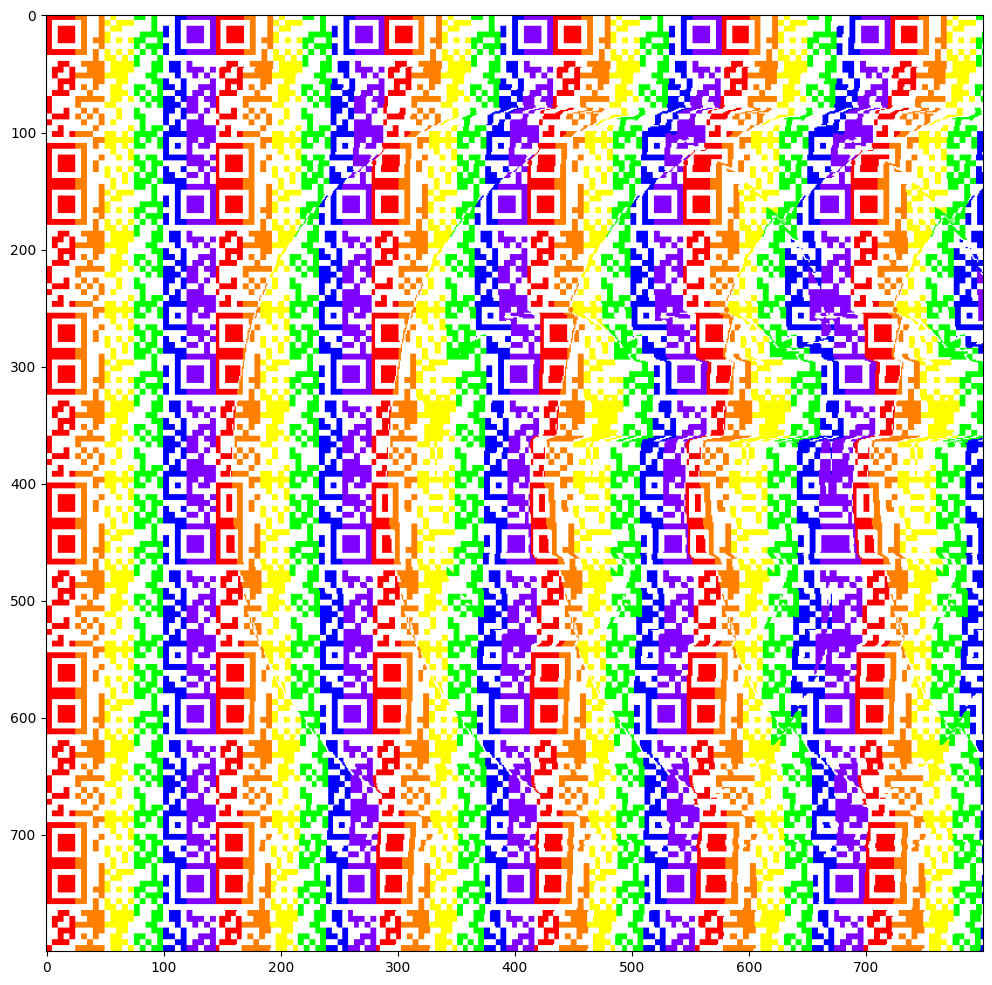

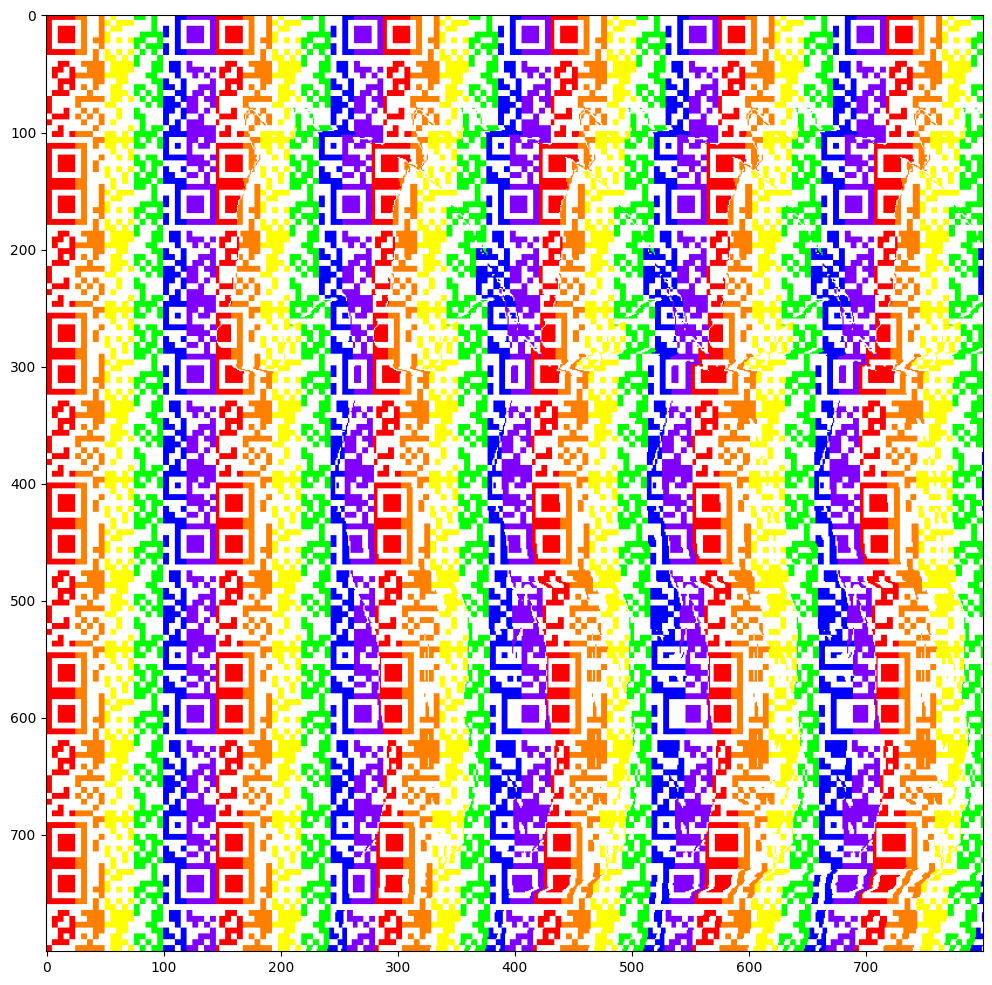

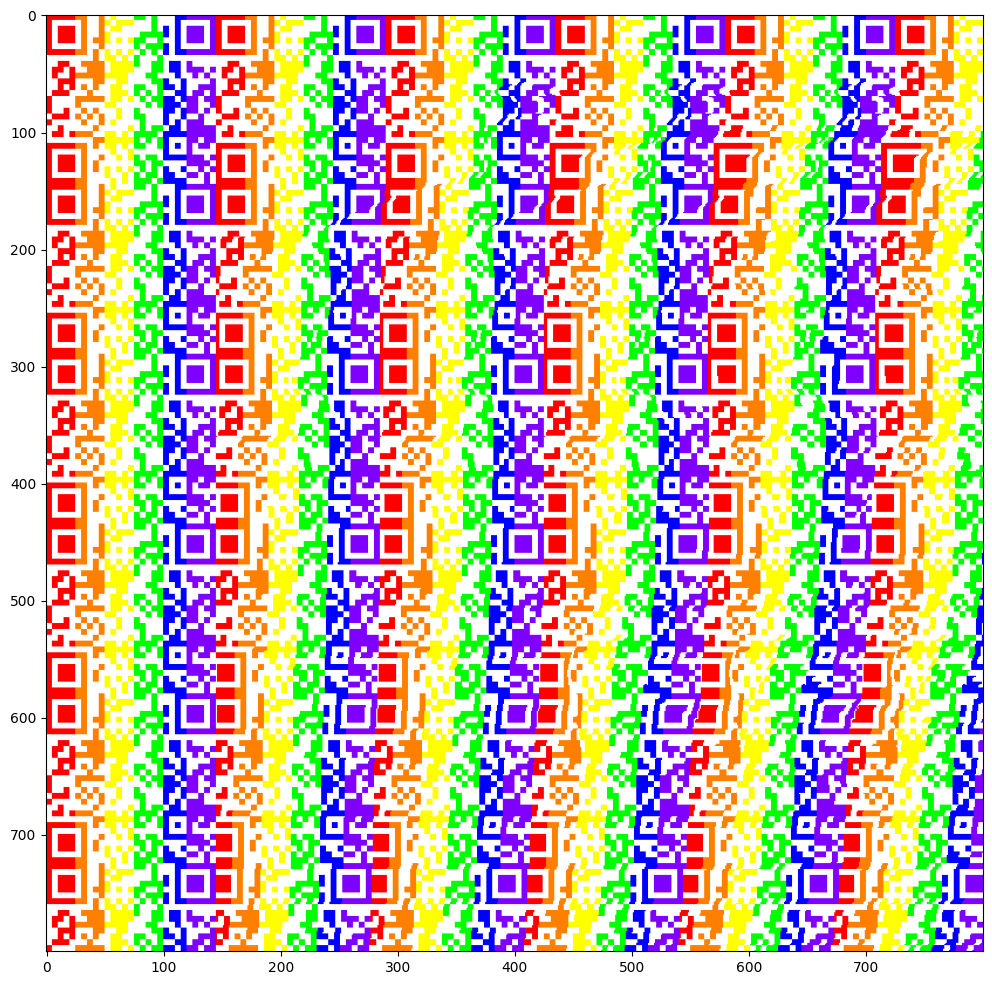

In [248]:
autostereogram = make_autostereogram(DM_LetterG, np.array(stripe_colored_qr))
display(autostereogram)
autostereogram = make_autostereogram(DM_Horse, np.array(stripe_colored_qr))
display(autostereogram)
autostereogram = make_autostereogram(DM_Farm, np.array(stripe_colored_qr))
display(autostereogram)